In [1]:
%load_ext watermark


In [2]:
import os

from IPython.display import display
import numpy as np
import pandas as pd
import seaborn as sns
from teeplot import teeplot as tp

import pylib  # noqa: F401


In [3]:
%watermark -diwmuv -iv


Last updated: 2026-02-16T14:24:04.159062+00:00

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.31.1

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 6.8.0-1044-azure
Machine     : x86_64
Processor   : x86_64
CPU cores   : 4
Architecture: 64bit

seaborn: 0.13.2
pylib  : 0.0.0
numpy  : 2.1.2
teeplot: 1.4.2
pandas : 2.2.3

Watermark: 2.4.3



In [4]:
teeplot_subdir = os.environ.get(
    "NOTEBOOK_NAME", "2025-10-27-trafficsim_msprime"
)
teeplot_subdir


'2025-10-28-trafficsim_msprime'

## Prep Data


In [5]:
df_traffic = pd.read_parquet("https://osf.io/download/7jv4d/")
display(df_traffic.describe()), display(df_traffic.head()), display(
    df_traffic.tail()
);


/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,population,migration_count,grid_dim,num_alleles,num_demes,deme_size,migration_rate,ploidy,random_seed,slurm_array_task_id,time_thresh
count,6.277950e+07,6.277950e+07,62779500.0,62779500.0,62779500.0,62779500.0,6.277950e+07,62779500.0,6.277950e+07,6.277950e+07,62779500.0
mean,4.495000e+02,2.345244e+03,30.0,512.0,900.0,512.0,5.000000e-02,1.0,4.998530e+03,4.997530e+03,inf
std,2.598075e+02,3.905598e+02,0.0,0.0,0.0,0.0,6.897261e-15,0.0,2.885078e+03,2.885078e+03,NaN
min,0.000000e+00,7.620000e+02,30.0,512.0,900.0,512.0,5.000000e-02,1.0,1.000000e+00,0.000000e+00,30000.0
25%,2.247500e+02,2.056000e+03,30.0,512.0,900.0,512.0,5.000000e-02,1.0,2.499000e+03,2.498000e+03,50000.0
50%,4.495000e+02,2.342000e+03,30.0,512.0,900.0,512.0,5.000000e-02,1.0,4.997000e+03,4.996000e+03,300000.0
75%,6.742500e+02,2.627000e+03,30.0,512.0,900.0,512.0,5.000000e-02,1.0,7.498000e+03,7.497000e+03,1000000.0
max,8.990000e+02,4.895000e+03,30.0,512.0,900.0,512.0,5.000000e-02,1.0,1.000000e+04,9.999000e+03,inf


,population,migration_count,grid_dim,num_alleles,num_demes,deme_size,migration_rate,ploidy,random_seed,slurm_array_task_id,time_thresh
0,433,2187,30,512,900,512,0.05,1,1,0,30000.0
1,307,2173,30,512,900,512,0.05,1,1,0,30000.0
2,434,2167,30,512,900,512,0.05,1,1,0,30000.0
3,835,2166,30,512,900,512,0.05,1,1,0,30000.0
4,404,2144,30,512,900,512,0.05,1,1,0,30000.0


,population,migration_count,grid_dim,num_alleles,num_demes,deme_size,migration_rate,ploidy,random_seed,slurm_array_task_id,time_thresh
62779495,360,1941,30,512,900,512,0.05,1,10,9,inf
62779496,870,1431,30,512,900,512,0.05,1,10,9,inf
62779497,899,1414,30,512,900,512,0.05,1,10,9,inf
62779498,0,1385,30,512,900,512,0.05,1,10,9,inf
62779499,29,1262,30,512,900,512,0.05,1,10,9,inf


In [6]:
df_duration = pd.read_parquet("https://osf.io/download/hrq6a/")
display(df_duration.describe()), display(df_duration.head()), display(
    df_duration.tail()
);


,population,origin_time,grid_dim,num_alleles,num_demes,deme_size,migration_rate,ploidy,random_seed,slurm_array_task_id
count,8.968500e+06,8.968500e+06,8968500.0,8968500.0,8968500.0,8968500.0,8.968500e+06,8968500.0,8.968500e+06,8.968500e+06
mean,4.495000e+02,9.263131e+05,30.0,512.0,900.0,512.0,5.000000e-02,1.0,4.998530e+03,4.997530e+03
std,2.598075e+02,4.995791e+05,0.0,0.0,0.0,0.0,8.951174e-16,0.0,2.885078e+03,2.885078e+03
min,0.000000e+00,1.202029e+05,30.0,512.0,900.0,512.0,5.000000e-02,1.0,1.000000e+00,0.000000e+00
25%,2.247500e+02,5.735996e+05,30.0,512.0,900.0,512.0,5.000000e-02,1.0,2.499000e+03,2.498000e+03
50%,4.495000e+02,8.012084e+05,30.0,512.0,900.0,512.0,5.000000e-02,1.0,4.997000e+03,4.996000e+03
75%,6.742500e+02,1.150903e+06,30.0,512.0,900.0,512.0,5.000000e-02,1.0,7.498000e+03,7.497000e+03
max,8.990000e+02,4.169518e+06,30.0,512.0,900.0,512.0,5.000000e-02,1.0,1.000000e+04,9.999000e+03


,population,origin_time,grid_dim,num_alleles,num_demes,deme_size,migration_rate,ploidy,random_seed,slurm_array_task_id
0,0,1.067435e+06,30,512,900,512,0.05,1,1,0
1,1,1.067425e+06,30,512,900,512,0.05,1,1,0
2,2,1.092280e+06,30,512,900,512,0.05,1,1,0
3,3,1.092293e+06,30,512,900,512,0.05,1,1,0
4,4,1.065254e+06,30,512,900,512,0.05,1,1,0


,population,origin_time,grid_dim,num_alleles,num_demes,deme_size,migration_rate,ploidy,random_seed,slurm_array_task_id
8968495,895,687200.542495,30,512,900,512,0.05,1,10,9
8968496,896,687228.729809,30,512,900,512,0.05,1,10,9
8968497,897,687214.052359,30,512,900,512,0.05,1,10,9
8968498,898,642508.366192,30,512,900,512,0.05,1,10,9
8968499,899,680029.280832,30,512,900,512,0.05,1,10,9


In [7]:
df_traffic.groupby(["num_demes", "time_thresh"])["migration_count"].max()


num_demes  time_thresh
900        30000.0        2419
           50000.0        2560
           100000.0       2785
           300000.0       3117
           500000.0       3279
           1000000.0      3674
           inf            4895
Name: migration_count, dtype: int64

In [8]:
df_traffic.groupby(["num_demes", "time_thresh"])["migration_count"].mean()


num_demes  time_thresh
900        30000.0        1920.638888
           50000.0        2024.801611
           100000.0       2168.102115
           300000.0       2403.926859
           500000.0       2518.949021
           1000000.0      2654.797407
           inf            2725.492275
Name: migration_count, dtype: float64

In [9]:
df_duration.groupby("num_demes")["origin_time"].max()


num_demes
900    4.169518e+06
Name: origin_time, dtype: float64

## Block sample data


In [10]:
(pop_size,) = df_traffic["deme_size"].unique()
pop_size


np.int64(512)

In [11]:
df_traffic["task_id"] = (
    df_traffic["slurm_array_task_id"].rank(method="dense").astype(int) - 1
)
df_traffic["block"] = df_traffic["task_id"] // 900

df_traffic_by_block = (
    df_traffic[df_traffic["block"] < 10]
    .groupby(
        ["block", "num_demes", "time_thresh"],
    )["migration_count"]
    .agg(["mean", "max"])
    .reset_index()
)
df_traffic_by_block


,block,num_demes,time_thresh,mean,max
0,0,900,30000.0,1921.730928,2369
1,0,900,50000.0,2026.086412,2544
2,0,900,100000.0,2169.161948,2712
3,0,900,300000.0,2406.953884,3068
4,0,900,500000.0,2521.763228,3226
...,...,...,...,...,...
65,9,900,100000.0,2167.828227,2754
66,9,900,300000.0,2404.881337,3060
67,9,900,500000.0,2522.505153,3223
68,9,900,1000000.0,2658.563788,3518


In [12]:
dfm = df_traffic_by_block.melt(
    id_vars=["block", "num_demes", "time_thresh"],
    value_vars=["mean", "max"],
    var_name="statistic",
    value_name="migration_count",
)


In [13]:
dfm["Memory Use (kB)"] = (dfm["migration_count"] + pop_size) * 8 / 1024


In [14]:
dfm["strategy"] = (
    "tracking\n(+prune)"
    + np.where(dfm["time_thresh"] != np.inf, "\n(+batch)", "")
    + np.where(dfm["statistic"] == "mean", "\n(+balance)", "")
)


In [15]:
dfm["flavor"] = "tracking"


## Plotting


In [16]:
dfp = pd.concat(
    [
        pd.DataFrame.from_records(
            [
                {
                    "flavor": "reconstruction",
                    "strategy": "reconst\n(32 bit)",
                    "Memory Use (kB)": pop_size * (4 + 4) / 1024,
                },
                {
                    "flavor": "reconstruction",
                    "strategy": "reconst\n(64 bit)",
                    "Memory Use (kB)": pop_size * (8 + 4) / 1024,
                },
                {
                    "flavor": "reconstruction",
                    "strategy": "reconst\n(256 bit)",
                    "Memory Use (kB)": pop_size * (32 + 4) / 1024,
                },
                {
                    "flavor": "tracking",
                    "strategy": "tracking\n(serial)",
                    "Memory Use (kB)": pop_size * 2 * (8 + 4) / 1024,
                },
            ]
        ),
        dfm[dfm["time_thresh"].isin([100_000, np.inf])],
    ],
    ignore_index=True,
)


teeplots/2025-10-28-trafficsim_msprime/hue=flavor+viz=barplot+x=strategy+y=memory-use-kb+ext=.pdf
teeplots/2025-10-28-trafficsim_msprime/hue=flavor+viz=barplot+x=strategy+y=memory-use-kb+ext=.png


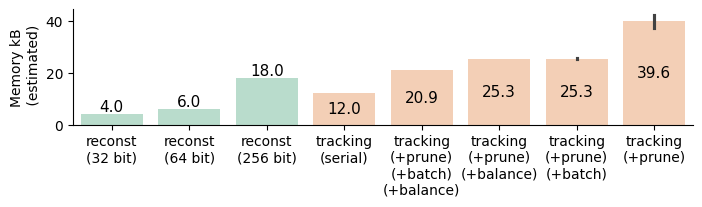

In [17]:
with tp.teed(
    sns.barplot,
    data=dfp,
    x="strategy",
    y="Memory Use (kB)",
    errorbar=("pi", 100),
    hue="flavor",
    legend=False,
    palette="Pastel2",
    teeplot_subdir=teeplot_subdir,
    teeplot_outexclude=["palette"],
) as ax:
    ax.figure.set_size_inches(8, 1.5)
    ax.set_ylim(0, None)
    ax.set_ylabel("Memory kB\n (estimated)")
    ax.set_xlabel("")
    sns.despine(ax=ax)
    for i, container in enumerate(ax.containers):
        ax.bar_label(
            container,
            fmt="%.1f",
            fontsize=11,
            label_type=["edge", "center"][i],
        )
